# IMDB 자료분석2

- 조금 더 깔끔하게

In [1]:
from tensorflow.keras.datasets import imdb
import numpy as np

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

## 1. 전처리 및 데이터 분리

In [2]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # 결과를 저장할 0 행렬 생성
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1 # 문장에 존재하는 단어들만 one-hot encoding
    return results

# 문장들을 일정한 크기의 벡터로 변환
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

# 리스트 형태인 레이블을 벡터로 변환
y_train = np.array(train_labels).astype('float32')
y_test = np.array(test_labels).astype('float32')

X_valid = X_train[:10000]
X_train = X_train[10000:]
y_valid = y_train[:10000]
y_train = y_train[10000:]

### Early Stopping

- 과적합이 되는 시점이 되었음에도 지정한 epoch 에 맞춰서 학습될텐데,
이걸 방지를 해주는 것이 early stopping 이다.
- patience = 3 으로 설정을 하면, loss가 떨어지지 않는데도 일단 3 epoch를 참고 넘어가겠다는거고,
- 그래도 loss가 안떨어지면 학습을 종료시킨다.

## 2. 모델 학습 (조기 종료 콜백함수 버전)

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

callbacks_list = [EarlyStopping(monitor='val_loss', patience=6),
                  ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]
# 여기서 filepath 를 절대경로로 하면 다른 환경에서 돌리면 error.
# 가급적이면 상대경로로 돌려주는 것이 좋음

history = model.fit(X_train, 
                    y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_valid, y_valid),
                    callbacks = callbacks_list)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 180us/step - loss: 0.4583 - acc: 0.8231 - val_loss: 0.3402 - val_acc: 0.8709
Epoch 2/20
15000/15000 [==============================] - 2s 147us/step - loss: 0.2450 - acc: 0.9145 - val_loss: 0.2756 - val_acc: 0.8913
Epoch 3/20
15000/15000 [==============================] - 2s 153us/step - loss: 0.1760 - acc: 0.9403 - val_loss: 0.2781 - val_acc: 0.8893
Epoch 4/20
15000/15000 [==============================] - 2s 151us/step - loss: 0.1366 - acc: 0.9535 - val_loss: 0.2955 - val_acc: 0.8865
Epoch 5/20
15000/15000 [==============================] - 2s 152us/step - loss: 0.1070 - acc: 0.9653 - val_loss: 0.3425 - val_acc: 0.8757
Epoch 6/20
15000/15000 [==============================] - 2s 154us/step - loss: 0.0838 - acc: 0.9723 - val_loss: 0.3585 - val_acc: 0.8794
Epoch 7/20
15000/15000 [==============================] - 2s 156us/step - loss: 0.0653 - acc: 0.9799 - val_loss: 0.3915 - 

## 3. 학습 과정 확인

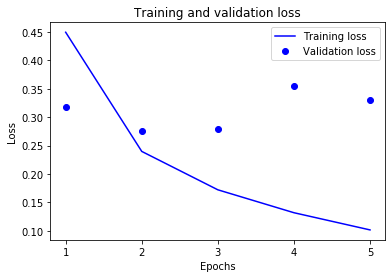

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss') # 'b'는 파란색 실선을 의미
plt.plot(epochs, val_loss, 'bo', label='Validation loss') # 'bo'는 파란색 점을 의미
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

## 4. 최적 모델 불러오기

In [5]:
from keras.models import load_model

model = load_model('model.h5')
print('>> model load!!')

>> model load!!


## 5. 성능 평가

In [6]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test loss: ', test_loss)
print('test acc: ', test_acc)

25000/25000 [==============================] - 3s 111us/step
test loss:  0.2910223377609253
test acc:  0.88384
